### Imports

In [64]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import random
from tensorflow.keras import metrics

# Keras (dentro de TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Configuración
warnings.filterwarnings('ignore')

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score,classification_report

In [43]:
def plot_matriz_confusion(axes,TP=0,TN=0,FP=0,FN=0,fontsize=15,vpp=None,vpn=None,sensibilidad=None,especificidad=None,f1_score=None,mcc=None,auc=None,prevalencia=None):
    success_color=matplotlib.colors.to_rgb('#9EE548')
    failure_color=matplotlib.colors.to_rgb("#C32240")
    blanco_color=matplotlib.colors.to_rgb("#FFFFFF")


    if ((vpp is not None) |
        (vpn is not None) |
        (sensibilidad is not None) |
        (especificidad is not None) |
        (prevalencia is not None) |
        (f1_score is not None) |
        (mcc is not None) |
        (auc is not None) ):
        show_metrics=True
    else:
        show_metrics=False


    if show_metrics==False:
        axes.imshow([[success_color,failure_color],[failure_color,success_color]])
    else:
        axes.imshow([[success_color,failure_color,blanco_color],[failure_color,success_color,blanco_color],[blanco_color,blanco_color,blanco_color]])



    labels = ['Positivo','Negativo']
    xaxis = np.arange(len(labels))
    axes.set_xticks(xaxis)
    axes.set_yticks(xaxis)
    axes.set_xticklabels(labels, fontsize=13, color="#003B80")
    axes.set_yticklabels(labels, fontsize=13, color="#003B80")
    axes.text(0, 0, str(TP)+" TP",ha="center", va="center", color="#0A2102",fontsize=fontsize)
    axes.text(0, 1, str(FP)+" FP",ha="center", va="center", color="#FAEAEA",fontsize=fontsize)
    axes.text(1, 0, str(FN)+" FN",ha="center", va="center", color="#FAEAEA",fontsize=fontsize)
    axes.text(1, 1, str(TN)+" TN",ha="center", va="center", color="#0A2102",fontsize=fontsize)
    axes.xaxis.tick_top()
    axes.set_xlabel('Predicción', fontsize=fontsize, color="#003B80")
    axes.xaxis.set_label_position('top')
    axes.set_ylabel('Realidad', fontsize=fontsize, color="#003B80")


    if show_metrics==True:


        if (vpp is not None):
            axes.text(0, 2, f"Precision\n{vpp:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)
        if (vpn is not None):
            axes.text(1, 2, f"VPN\n{vpn:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)
        if (sensibilidad is not None):
            axes.text(2, 0, f"Sensibilidad\n{sensibilidad:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)
        if (especificidad is not None):
            axes.text(2, 1, f"Especificidad\n{especificidad:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)

        metricas_generales=""
        if (prevalencia is not None):
            metricas_generales=metricas_generales+f"Prevalencia\n{prevalencia:.2f}\n"
        if (f1_score is not None):
            metricas_generales=metricas_generales+f"F1-score\n{f1_score:.2f}\n"
        if (mcc is not None):
            metricas_generales=metricas_generales+f"MCC\n{mcc:.2f}\n"
        if (auc is not None):
            metricas_generales=metricas_generales+f"AUC\n{auc:.2f}"

        axes.text(2, 2, metricas_generales,ha="center", va="center", color="#0A2102",fontsize=fontsize-4)

### Descargar dataset

In [44]:
#!/bin/bash
!kaggle datasets download -d alexteboul/heart-disease-health-indicators-dataset -p . --unzip

Dataset URL: https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset
License(s): CC0-1.0




  0%|          | 0.00/2.66M [00:00<?, ?B/s]
 38%|███▊      | 1.00M/2.66M [00:00<00:00, 1.91MB/s]
100%|██████████| 2.66M/2.66M [00:00<00:00, 4.60MB/s]
100%|██████████| 2.66M/2.66M [00:00<00:00, 3.96MB/s]


In [45]:
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
df

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


### Compruebo valores unicos de cada columna

In [46]:
x = 0
for i in df:
    print(f'{df.columns[x]}\n {df[i].unique()}\n')
    x = x + 1

HeartDiseaseorAttack
 [0. 1.]

HighBP
 [1. 0.]

HighChol
 [1. 0.]

CholCheck
 [1. 0.]

BMI
 [40. 25. 28. 27. 24. 30. 34. 26. 33. 21. 23. 22. 38. 32. 37. 31. 29. 20.
 35. 45. 39. 19. 47. 18. 36. 43. 55. 49. 42. 17. 16. 41. 44. 50. 59. 48.
 52. 46. 54. 57. 53. 14. 15. 51. 58. 63. 61. 56. 74. 62. 64. 66. 73. 85.
 60. 67. 65. 70. 82. 79. 92. 68. 72. 88. 96. 13. 81. 71. 75. 12. 77. 69.
 76. 87. 89. 84. 95. 98. 91. 86. 83. 80. 90. 78.]

Smoker
 [1. 0.]

Stroke
 [0. 1.]

Diabetes
 [0. 2. 1.]

PhysActivity
 [0. 1.]

Fruits
 [0. 1.]

Veggies
 [1. 0.]

HvyAlcoholConsump
 [0. 1.]

AnyHealthcare
 [1. 0.]

NoDocbcCost
 [0. 1.]

GenHlth
 [5. 3. 2. 4. 1.]

MentHlth
 [18.  0. 30.  3.  5. 15. 10.  6. 20.  2. 25.  1.  4.  7.  8. 21. 14. 26.
 29. 16. 28. 11. 12. 24. 17. 13. 27. 19. 22.  9. 23.]

PhysHlth
 [15.  0. 30.  2. 14. 28.  7. 20.  3. 10.  1.  5. 17.  4. 19.  6. 12. 25.
 27. 21. 22.  8. 29. 24.  9. 16. 18. 23. 13. 26. 11.]

DiffWalk
 [1. 0.]

Sex
 [0. 1.]

Age
 [ 9.  7. 11. 10.  8. 13.  4.  6.  2.

### Compruebo valores nulos de cada columna

In [47]:
df.isnull().sum()

HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

### Datos de prueba

In [48]:
X = df.drop(['HeartDiseaseorAttack'], axis=1)
y = df['HeartDiseaseorAttack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Columnas de X_train: {X_train.columns.tolist()}")

Forma de X_train: (202944, 21)
Columnas de X_train: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [50]:
class Especificidad(tf.keras.metrics.Metric):
    def __init__(self, name="especificidad", **kwargs):
        super(Especificidad, self).__init__(name=name, **kwargs)
        self.true_negatives = self.add_weight(name="tn", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convertir a float32 para evitar conflictos de tipo
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        self.true_negatives.assign_add(tn)
        self.false_positives.assign_add(fp)

    def result(self):
        return self.true_negatives / (self.true_negatives + self.false_positives + tf.keras.backend.epsilon())

    def reset_states(self):
        self.true_negatives.assign(0.0)
        self.false_positives.assign(0.0)

In [51]:
class Sensibilidad(tf.keras.metrics.Metric):
    def __init__(self, name="sensibilidad", **kwargs):
        super(Sensibilidad, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convertir a float32 para evitar conflictos de tipo
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)  # Redondeamos para obtener las predicciones binarias
        tp = tf.reduce_sum(y_true * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        self.true_positives.assign_add(tp)
        self.false_negatives.assign_add(fn)

    def result(self):
        return self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())

    def reset_states(self):
        self.true_positives.assign(0.0)
        self.false_negatives.assign(0.0)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=21))
model.add(BatchNormalization())  # Normaliza entradas para mejor estabilidad
model.add(Dropout(0.3))  # Evita sobreajuste

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Optimización con tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['Recall'])

### Entrenamiento del modelo

In [66]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - Recall: 0.0711 - auc: 0.7438 - loss: 0.3219 - precision: 0.1603 - val_Recall: 0.0382 - val_auc: 0.8452 - val_loss: 0.2404 - val_precision: 0.6642
Epoch 2/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - Recall: 0.0241 - auc: 0.8292 - loss: 0.2474 - precision: 0.5203 - val_Recall: 0.0405 - val_auc: 0.8479 - val_loss: 0.2429 - val_precision: 0.6498
Epoch 3/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - Recall: 0.0295 - auc: 0.8366 - loss: 0.2435 - precision: 0.5346 - val_Recall: 0.0206 - val_auc: 0.8474 - val_loss: 0.2377 - val_precision: 0.7481
Epoch 4/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - Recall: 0.0313 - auc: 0.8369 - loss: 0.2429 - precision: 0.5042 - val_Recall: 0.1227 - val_auc: 0.8453 - val_loss: 0.2391 - val_precision: 0.5342
Epoch 5/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - Recall: 0.0332 - auc: 0.8345 - loss: 0.2448 - precision: 0.5246 - val_Recall: 0.0432 - val_auc: 0.8479 - val_loss: 0.2383 - val_pre

In [83]:
import numpy as np

#x_test = x
#y_test = y # y_true

def get_matriz_confusion(y_true, y_score, threshold=0.05):
    y_pred = (y_score >= threshold).astype(int)
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    return {"TP": TP, "FP": FP, "TN": TN, "FN": FN}

y_score = model.predict(X_test).ravel()  # Convierte un array multidimensional en un vector unidimensional
matriz_conf = get_matriz_confusion(y_test, y_score)
print(matriz_conf)


1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step
{'TP': np.int64(4264), 'FP': np.int64(17326), 'TN': np.int64(28642), 'FN': np.int64(504)}


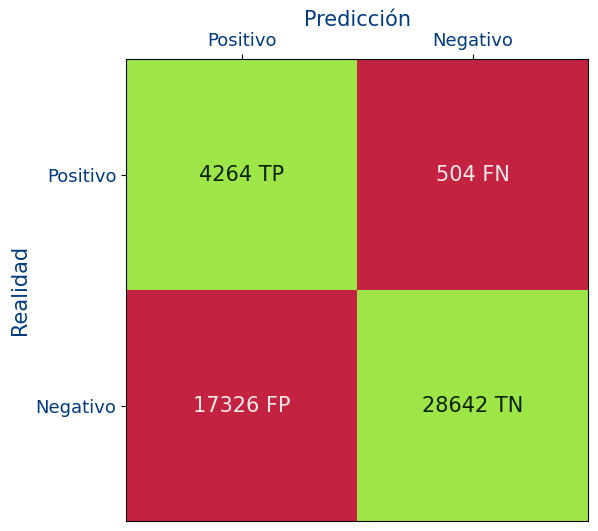

In [84]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_matriz_confusion(ax, matriz_conf['TP'], matriz_conf['TN'], matriz_conf['FP'], matriz_conf['FN'])